In [ ]:
# # download dataset
# ! kaggle datasets download -p data vikramtiwari/pix2pix-dataset 
# ! cd ./data && unzip pix2pix-dataset.zip

pix2pix-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pix2pix-dataset.zip
replace cityscapes/cityscapes/train/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [15]:
import functools
from pathlib import Path

import cv2
import torch
import numpy as np
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import save_image, make_grid

from IPython.display import clear_output
%matplotlib inline


DATA_DIR = Path("./data/facades/facades")
RUN_EXP_DIR = Path("./runs")
ARTIFACTS_DIR = RUN_EXP_DIR / "artifacts"
CHECKPOINT_DIR = RUN_EXP_DIR / "checkpoints"
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)
CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)

N_EPOCHS = 300
G_LR = 2e-5
D_LR = 2e-6
BATCH_SIZE = 16
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
DEVICE

device(type='cuda')

# Data

In [24]:
class FacadesDataset(Dataset):
    def __init__(self, data_dir: Path, stage="train", transform=None) -> None:
        self._images_paths = list((data_dir / stage).iterdir())
        self._transform = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, idx):        
        img = Image.open(self._images_paths[idx])
        w, h = img.size
        img_target = img.crop((0, 0, w / 2, h))
        img_input = img.crop((w / 2, 0, w, h))
        
        if np.random.random() < 0.5:
            img_target = Image.fromarray(np.array(img_target)[:, ::-1, :], "RGB")
            img_input = Image.fromarray(np.array(img_input)[:, ::-1, :], "RGB")

        if self._transform:
            img_target = self._transform(img_target)
            img_input = self._transform(img_input)

        return img_input, img_target

    def __len__(self):
        return len(self._images_paths)


In [25]:
train_ds = FacadesDataset(DATA_DIR, "train", train_transform)
valid_ds = FacadesDataset(DATA_DIR, "val", transform)
test_ds = FacadesDataset(DATA_DIR, "test", transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# Generator

In [26]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.unet = smp.Unet(
            "resnet34",
            in_channels=3,
            classes=3,
            encoder_depth=5,
            encoder_weights="imagenet",
            decoder_channels=(256, 128, 64, 32, 16)
        )

    def forward(self, x):
        out = self.unet(x)
        return out

# Discriminator

In [27]:
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw), nn.Sigmoid()]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

# Train

In [28]:
generator = Generator().to(DEVICE)
discriminator = Discriminator(6, 64).to(DEVICE)

G_optimizer = torch.optim.Adam(generator.parameters(), lr=G_LR, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=D_LR, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()

def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    return gen_total_loss

def discriminator_loss(output, label):
    return adversarial_loss(output, label)

  0%|          | 0/300 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


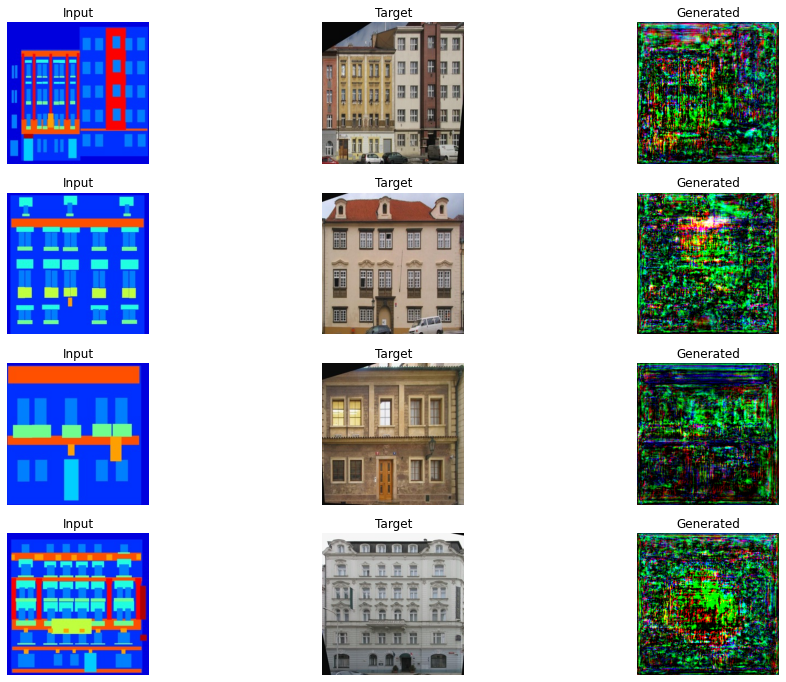

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


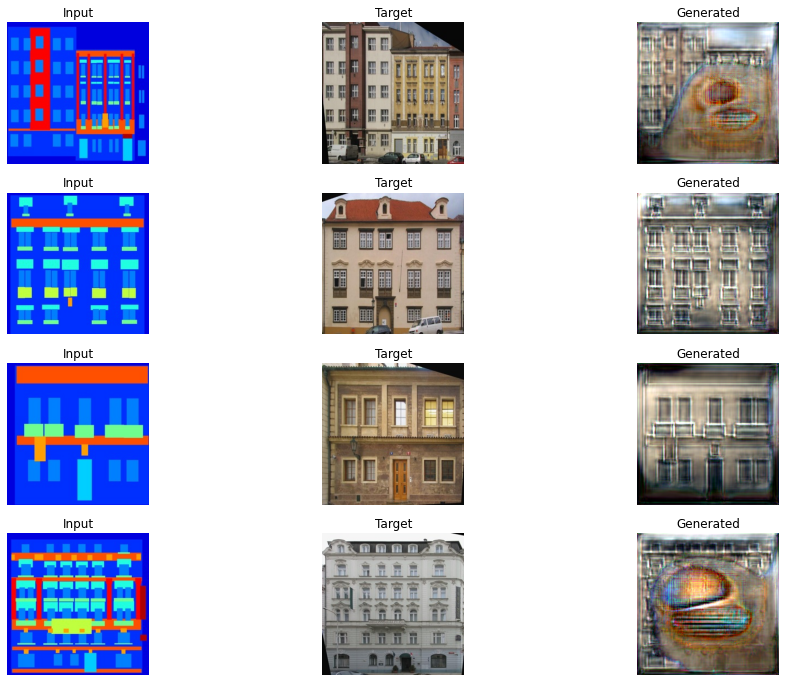

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


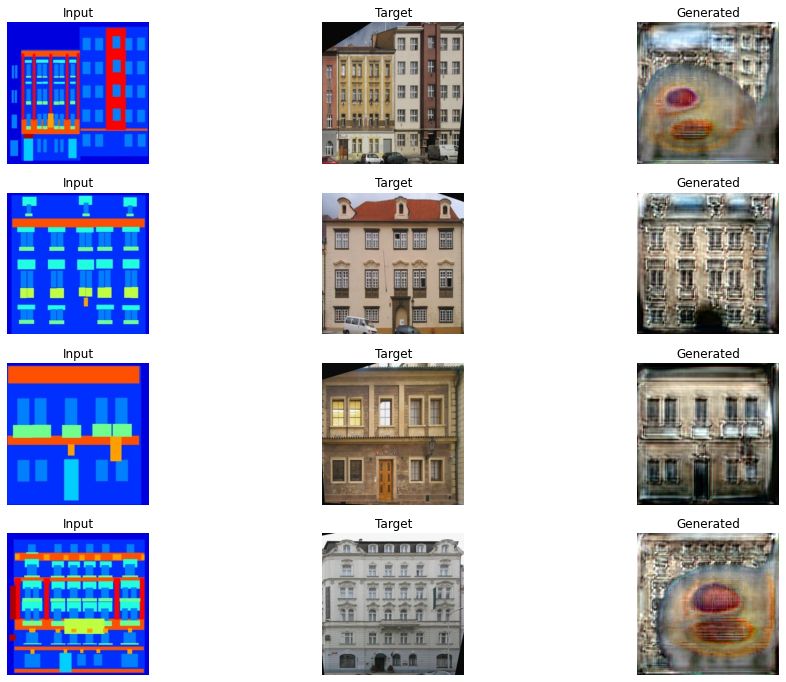

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


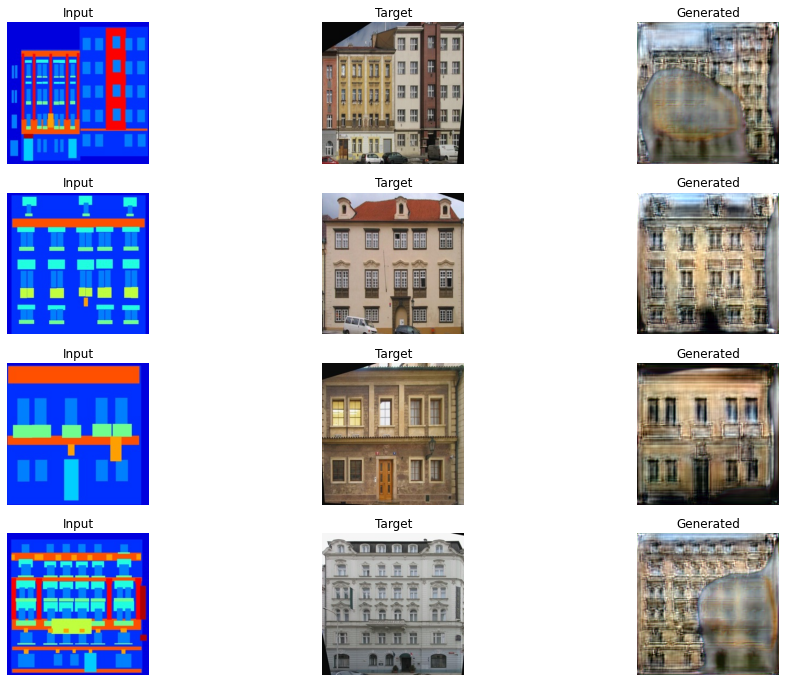

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


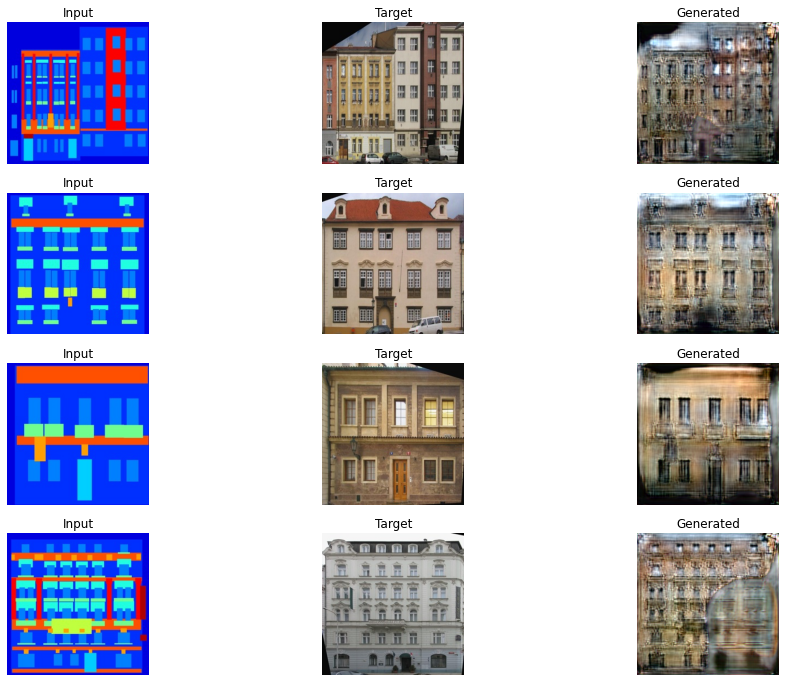

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


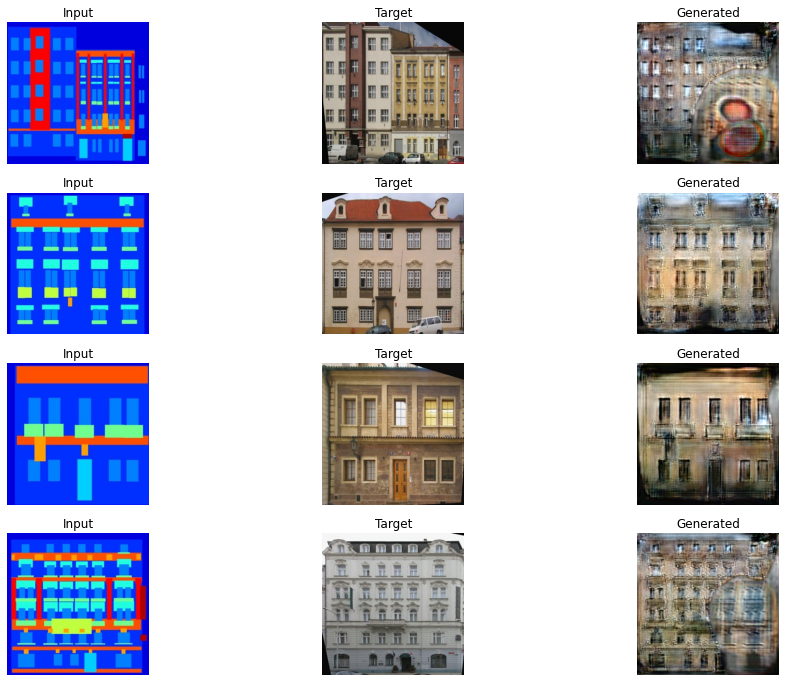

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


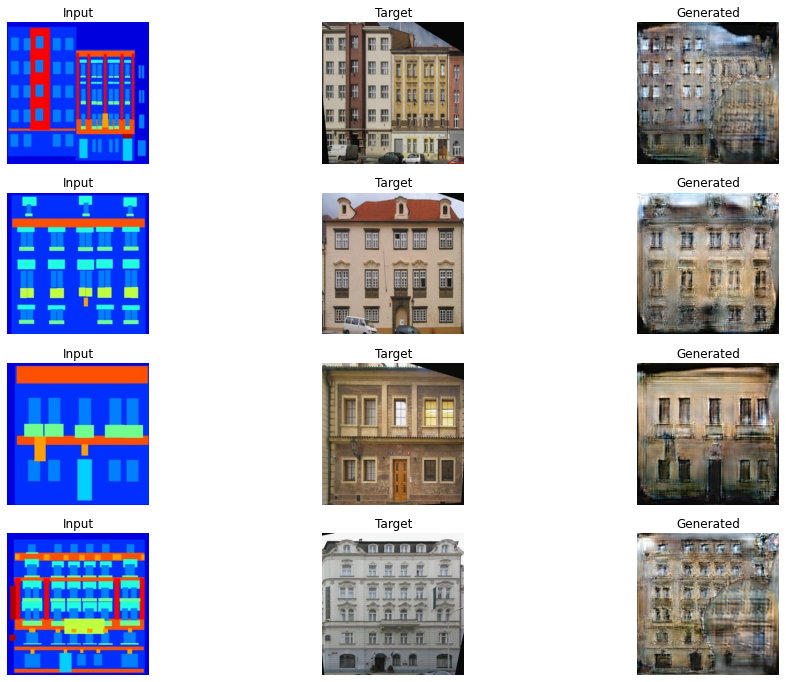

In [29]:
D_epoch_losses, G_epoch_losses= [], []

pbar = tqdm(total=N_EPOCHS)
for epoch in range(1, N_EPOCHS + 1): 
    D_loss_list, G_loss_list = [], []
   
    for input_img, target_img in train_loader:
        input_img = input_img.to(DEVICE)
        target_img = target_img.to(DEVICE)
       
        # ground truth labels real and fake
        real_target = torch.ones(input_img.size(0), 1, 30, 30, requires_grad=True).to(DEVICE)
        fake_target = torch.zeros(input_img.size(0), 1, 30, 30, requires_grad=True).to(DEVICE)
    
        # generator forward pass
        generated_img = generator(input_img.float())
        
        # train discriminator with fake/generated images
        D_fake_input = torch.cat((input_img, generated_img), 1)
        D_fake_output = discriminator(D_fake_input.detach())
        D_fake_loss = discriminator_loss(D_fake_output, fake_target)
        
        # train discriminator with real images
        D_real_input = torch.cat((input_img, target_img), 1)        
        D_real_output = discriminator(D_real_input.float())
        D_real_loss = discriminator_loss(D_real_output,  real_target)

        # average discriminator loss
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss.item())
        
        # compute gradients and run optimizer step
        D_optimizer.zero_grad()
        D_total_loss.backward()
        D_optimizer.step()
        
        
        # Train generator with real labels
        G_fake_input = torch.cat((input_img, generated_img), 1)
        G = discriminator(G_fake_input)
        G_loss = generator_loss(generated_img, target_img, G, real_target)                                 
        G_loss_list.append(G_loss.item())
        
        # compute gradients and run optimizer step
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
            
    D_epoch_losses.append(np.mean(D_loss_list))
    G_epoch_losses.append(np.mean(G_loss_list))
     
    pbar.update(1)
    pbar.set_description(
        f"D_loss: {D_epoch_losses[-1]:.4f} G_loss: {G_epoch_losses[-1]:.4f}"
    )

    if epoch % 50 == 0 or epoch == 1:
        torch.save(generator.state_dict(), CHECKPOINT_DIR / f"generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), CHECKPOINT_DIR / f"discriminator_epoch_{epoch}.pth")

        input_img, target_img = next(iter(valid_loader))
        input_img = input_img.to(DEVICE)
        target_img = target_img.to(DEVICE)
        with torch.no_grad():
            generated_img = generator(input_img.float())
        
        imgs = [input_img, target_img, generated_img]
        figure, axs = plt.subplots(4, 3, figsize=(16, 12))
        for i in range(len(axs)):
            for j, title in enumerate(["Input", "Target", "Generated"]):
                axs[i, j].imshow(imgs[j][i].permute(1, 2, 0).cpu().numpy())
                axs[i, j].axis("off")
                axs[i, j].set_title(title)
        plt.savefig(ARTIFACTS_DIR / f"./pix2pix_sample_{epoch}.png")
        plt.show()

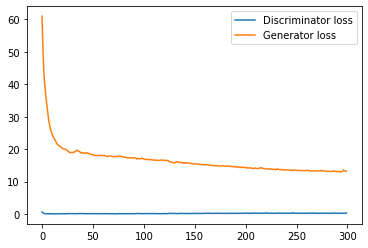

In [30]:
plt.plot(D_epoch_losses)
plt.plot(G_epoch_losses)
plt.legend(['Discriminator loss', 'Generator loss'])